# Branching Network Analysis

**Part II: Metabolic Scaling Theory and Biological Fractals**

---

## Overview

This notebook provides tools for analyzing branching networks, both synthetic (L-systems, recursive fractals) and biological (from images). We implement methods to measure branching ratios, verify MST predictions, and visualize network properties.

## Learning Objectives

By the end of this notebook, you will be able to:

1. Generate synthetic branching networks with known parameters
2. Extract branching statistics from network structures
3. Measure radius and length ratios at different branching levels
4. Compare observed ratios to MST predictions
5. Visualize asymmetry in biological branching patterns

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy import ndimage
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

## 1. Generating Synthetic Branching Networks

We'll create branching networks with explicit control over:
- Number of branching levels
- Branching number (bifurcation, trifurcation, etc.)
- Radius ratio ($\xi$)
- Length ratio ($\gamma$)
- Branching angles

This allows us to test our analysis methods against known ground truth.

In [2]:
class Branch:
    """Represents a single branch segment in a network."""
    
    def __init__(self, x, y, length, radius, angle, level, parent=None):
        self.x = x  # Starting x position
        self.y = y  # Starting y position
        self.length = length
        self.radius = radius
        self.angle = angle  # In radians
        self.level = level  # Branching order (0 = trunk)
        self.parent = parent
        self.children = []
        
        # Compute end point
        self.end_x = x + length * np.cos(angle)
        self.end_y = y + length * np.sin(angle)
    
    def get_midpoint(self):
        return ((self.x + self.end_x) / 2, (self.y + self.end_y) / 2)
    
    def get_volume(self):
        """Volume of cylindrical branch."""
        return np.pi * self.radius**2 * self.length
    
    def get_surface_area(self):
        """Surface area of cylindrical branch."""
        return 2 * np.pi * self.radius * self.length


class BranchingNetwork:
    """
    A hierarchical branching network with configurable parameters.
    """
    
    def __init__(self, n=2, xi=None, gamma=None, max_level=8, 
                 trunk_length=1.0, trunk_radius=0.1, 
                 angle_spread=np.pi/6, asymmetric=False):
        """
        Parameters:
        -----------
        n : int
            Branching number (2 = binary, 3 = ternary, etc.)
        xi : float
            Radius ratio. If None, uses MST prediction n^(-1/2)
        gamma : float
            Length ratio. If None, uses MST prediction n^(-1/3)
        max_level : int
            Maximum branching depth
        trunk_length : float
            Initial trunk length
        trunk_radius : float
            Initial trunk radius
        angle_spread : float
            Angular spread between branches (radians)
        asymmetric : bool
            If True, adds randomness to create asymmetric branching
        """
        self.n = n
        self.xi = xi if xi is not None else n ** (-1/2)
        self.gamma = gamma if gamma is not None else n ** (-1/3)
        self.max_level = max_level
        self.trunk_length = trunk_length
        self.trunk_radius = trunk_radius
        self.angle_spread = angle_spread
        self.asymmetric = asymmetric
        
        self.branches = []
        self._generate()
    
    def _generate(self):
        """Generate the branching network."""
        # Create trunk
        trunk = Branch(0, 0, self.trunk_length, self.trunk_radius, 
                       np.pi/2, level=0)
        self.branches.append(trunk)
        
        # Recursive branching
        self._branch(trunk)
    
    def _branch(self, parent):
        """Recursively create child branches."""
        if parent.level >= self.max_level:
            return
        
        # Calculate child parameters
        new_length = parent.length * self.gamma
        new_radius = parent.radius * self.xi
        
        # Distribute angles
        if self.n == 2:
            angles = [-self.angle_spread, self.angle_spread]
        else:
            angles = np.linspace(-self.angle_spread * (self.n-1)/2,
                                self.angle_spread * (self.n-1)/2,
                                self.n)
        
        for i, angle_offset in enumerate(angles):
            # Add asymmetry if requested
            if self.asymmetric:
                length_factor = 0.8 + 0.4 * np.random.random()
                radius_factor = 0.9 + 0.2 * np.random.random()
                angle_noise = 0.1 * (np.random.random() - 0.5)
            else:
                length_factor = 1.0
                radius_factor = 1.0
                angle_noise = 0
            
            child = Branch(
                x=parent.end_x,
                y=parent.end_y,
                length=new_length * length_factor,
                radius=new_radius * radius_factor,
                angle=parent.angle + angle_offset + angle_noise,
                level=parent.level + 1,
                parent=parent
            )
            
            parent.children.append(child)
            self.branches.append(child)
            
            # Recurse
            self._branch(child)
    
    def get_branches_at_level(self, level):
        """Get all branches at a specific level."""
        return [b for b in self.branches if b.level == level]
    
    def get_statistics(self):
        """Compute branching statistics."""
        stats = defaultdict(dict)
        
        for level in range(self.max_level + 1):
            branches = self.get_branches_at_level(level)
            if branches:
                lengths = [b.length for b in branches]
                radii = [b.radius for b in branches]
                
                stats[level] = {
                    'count': len(branches),
                    'mean_length': np.mean(lengths),
                    'std_length': np.std(lengths),
                    'mean_radius': np.mean(radii),
                    'std_radius': np.std(radii),
                    'total_volume': sum(b.get_volume() for b in branches),
                }
        
        return dict(stats)
    
    def measure_branching_ratios(self):
        """Measure actual branching ratios between levels."""
        stats = self.get_statistics()
        
        xi_measured = []
        gamma_measured = []
        
        for level in range(self.max_level):
            if level in stats and level + 1 in stats:
                xi = stats[level + 1]['mean_radius'] / stats[level]['mean_radius']
                gamma = stats[level + 1]['mean_length'] / stats[level]['mean_length']
                xi_measured.append(xi)
                gamma_measured.append(gamma)
        
        return np.array(xi_measured), np.array(gamma_measured)
    
    def plot(self, ax=None, color_by='level', show_radii=True):
        """Visualize the branching network."""
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 10))
        
        for branch in self.branches:
            if color_by == 'level':
                color = plt.cm.viridis(1 - branch.level / self.max_level)
            elif color_by == 'radius':
                color = plt.cm.hot(branch.radius / self.trunk_radius)
            else:
                color = 'brown'
            
            if show_radii:
                linewidth = max(0.5, branch.radius * 50)
            else:
                linewidth = 2
            
            ax.plot([branch.x, branch.end_x], [branch.y, branch.end_y],
                   color=color, linewidth=linewidth, solid_capstyle='round')
        
        ax.set_aspect('equal')
        ax.axis('off')
        return ax

print("BranchingNetwork class defined.")

BranchingNetwork class defined.


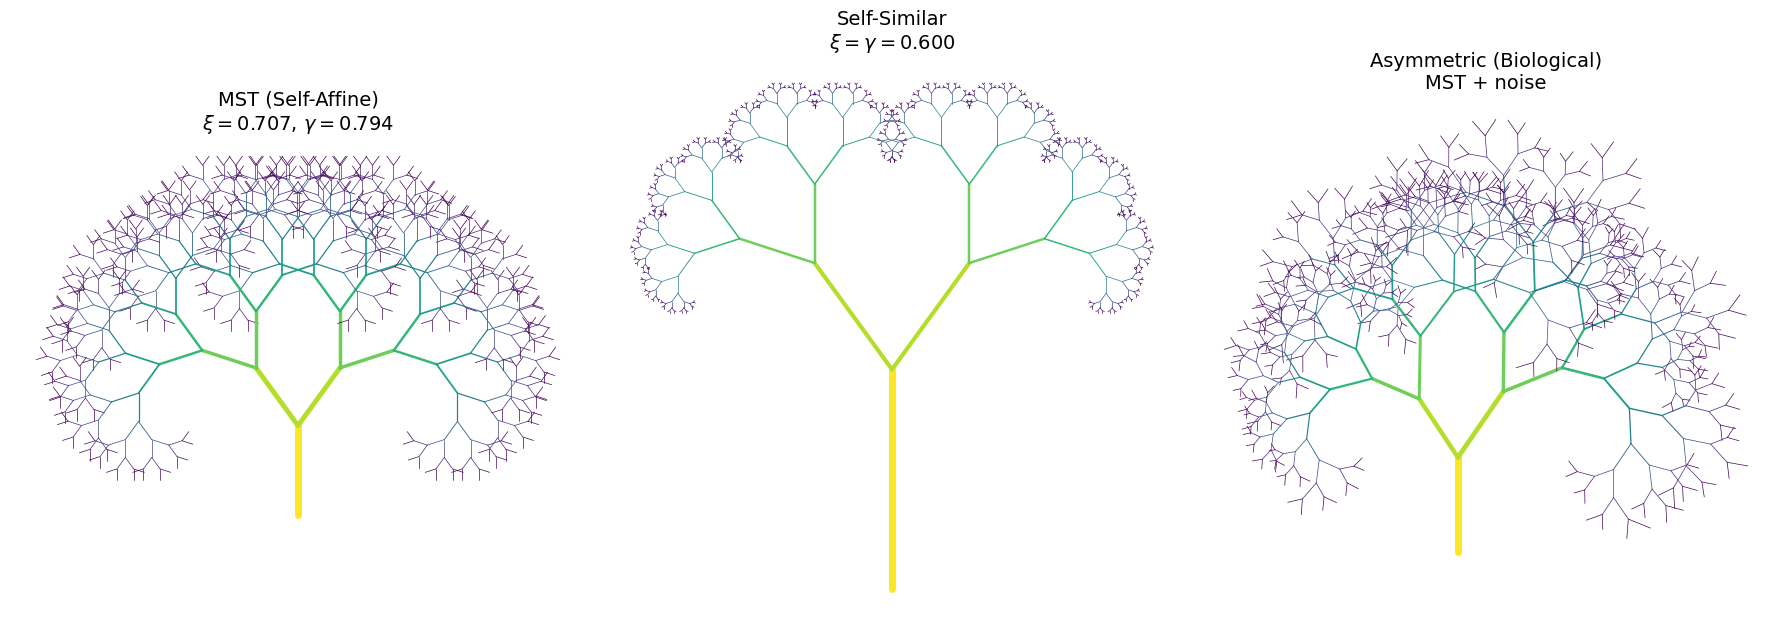

In [3]:
def generate_and_compare_networks():
    """Generate networks with MST parameters and self-similar parameters."""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    
    # Network 1: MST parameters (self-affine)
    net_mst = BranchingNetwork(n=2, max_level=9, angle_spread=np.pi/5)
    net_mst.plot(axes[0])
    axes[0].set_title(f'MST (Self-Affine)\n$\\xi = {net_mst.xi:.3f}$, $\\gamma = {net_mst.gamma:.3f}$',
                      fontsize=14)
    
    # Network 2: Self-similar (same ratio for both)
    ratio = 0.6
    net_ss = BranchingNetwork(n=2, xi=ratio, gamma=ratio, max_level=9, angle_spread=np.pi/5)
    net_ss.plot(axes[1])
    axes[1].set_title(f'Self-Similar\n$\\xi = \\gamma = {ratio:.3f}$', fontsize=14)
    
    # Network 3: Asymmetric biological-like
    net_bio = BranchingNetwork(n=2, max_level=9, angle_spread=np.pi/5, asymmetric=True)
    net_bio.plot(axes[2])
    axes[2].set_title(f'Asymmetric (Biological)\nMST + noise', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return net_mst, net_ss, net_bio

net_mst, net_ss, net_bio = generate_and_compare_networks()

## 2. Extracting Branching Statistics

Now we'll extract and analyze the branching statistics from our generated networks.

In [4]:
def analyze_network_statistics(network, name="Network"):
    """Analyze and display branching statistics."""
    
    stats = network.get_statistics()
    xi_meas, gamma_meas = network.measure_branching_ratios()
    
    print(f"\n{'='*60}")
    print(f"Statistics for: {name}")
    print(f"{'='*60}")
    print(f"\nExpected ratios: ξ = {network.xi:.4f}, γ = {network.gamma:.4f}")
    print(f"Measured ratios: ξ = {np.mean(xi_meas):.4f} ± {np.std(xi_meas):.4f}")
    print(f"                 γ = {np.mean(gamma_meas):.4f} ± {np.std(gamma_meas):.4f}")
    
    print(f"\n{'Level':<8} {'Count':<10} {'Mean Length':<15} {'Mean Radius':<15} {'Volume':<12}")
    print("-" * 60)
    
    for level, data in stats.items():
        print(f"{level:<8} {data['count']:<10} {data['mean_length']:<15.6f} "
              f"{data['mean_radius']:<15.6f} {data['total_volume']:<12.6f}")
    
    return stats, xi_meas, gamma_meas

# Analyze all three networks
stats_mst, xi_mst, gamma_mst = analyze_network_statistics(net_mst, "MST Network")
stats_ss, xi_ss, gamma_ss = analyze_network_statistics(net_ss, "Self-Similar Network")
stats_bio, xi_bio, gamma_bio = analyze_network_statistics(net_bio, "Asymmetric Network")


Statistics for: MST Network

Expected ratios: ξ = 0.7071, γ = 0.7937
Measured ratios: ξ = 0.7071 ± 0.0000
                 γ = 0.7937 ± 0.0000

Level    Count      Mean Length     Mean Radius     Volume      
------------------------------------------------------------
0        1          1.000000        0.100000        0.031416    
1        2          0.793701        0.070711        0.024935    
2        4          0.629961        0.050000        0.019791    
3        8          0.500000        0.035355        0.015708    
4        16         0.396850        0.025000        0.012467    
5        32         0.314980        0.017678        0.009895    
6        64         0.250000        0.012500        0.007854    
7        128        0.198425        0.008839        0.006234    
8        256        0.157490        0.006250        0.004948    
9        512        0.125000        0.004419        0.003927    

Statistics for: Self-Similar Network

Expected ratios: ξ = 0.6000, γ = 0.6000


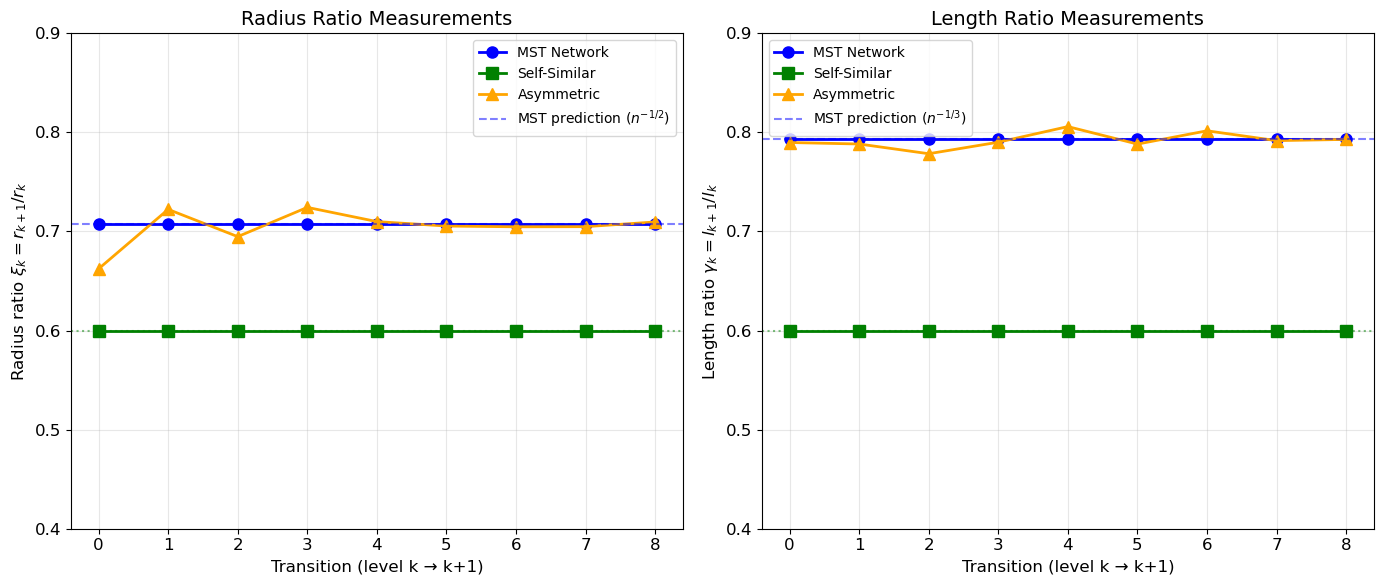

Key observations:
  - MST network: ξ ≈ 0.707, γ ≈ 0.794
  - MST predicts: ξ = 0.707, γ = 0.794
  - Self-similar has ξ = γ (isotropic scaling)
  - Asymmetric shows variability but same mean


In [5]:
def plot_branching_ratios():
    """Visualize measured branching ratios."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    levels = np.arange(len(xi_mst))
    
    # Plot radius ratios (xi)
    ax1 = axes[0]
    ax1.plot(levels, xi_mst, 'o-', color='blue', linewidth=2, 
             markersize=8, label='MST Network')
    ax1.plot(levels, xi_ss[:len(levels)], 's-', color='green', linewidth=2, 
             markersize=8, label='Self-Similar')
    ax1.plot(levels, xi_bio[:len(levels)], '^-', color='orange', linewidth=2, 
             markersize=8, label='Asymmetric')
    
    ax1.axhline(y=net_mst.xi, color='blue', linestyle='--', alpha=0.5, 
                label=f'MST prediction ($n^{{-1/2}}$)')
    ax1.axhline(y=0.6, color='green', linestyle=':', alpha=0.5)
    
    ax1.set_xlabel('Transition (level k → k+1)', fontsize=12)
    ax1.set_ylabel('Radius ratio $\\xi_k = r_{k+1}/r_k$', fontsize=12)
    ax1.set_title('Radius Ratio Measurements', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.4, 0.9)
    
    # Plot length ratios (gamma)
    ax2 = axes[1]
    ax2.plot(levels, gamma_mst, 'o-', color='blue', linewidth=2, 
             markersize=8, label='MST Network')
    ax2.plot(levels, gamma_ss[:len(levels)], 's-', color='green', linewidth=2, 
             markersize=8, label='Self-Similar')
    ax2.plot(levels, gamma_bio[:len(levels)], '^-', color='orange', linewidth=2, 
             markersize=8, label='Asymmetric')
    
    ax2.axhline(y=net_mst.gamma, color='blue', linestyle='--', alpha=0.5,
                label=f'MST prediction ($n^{{-1/3}}$)')
    ax2.axhline(y=0.6, color='green', linestyle=':', alpha=0.5)
    
    ax2.set_xlabel('Transition (level k → k+1)', fontsize=12)
    ax2.set_ylabel('Length ratio $\\gamma_k = l_{k+1}/l_k$', fontsize=12)
    ax2.set_title('Length Ratio Measurements', fontsize=14)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0.4, 0.9)
    
    plt.tight_layout()
    plt.show()
    
    print("Key observations:")
    print(f"  - MST network: ξ ≈ {np.mean(xi_mst):.3f}, γ ≈ {np.mean(gamma_mst):.3f}")
    print(f"  - MST predicts: ξ = {2**(-0.5):.3f}, γ = {2**(-1/3):.3f}")
    print(f"  - Self-similar has ξ = γ (isotropic scaling)")
    print(f"  - Asymmetric shows variability but same mean")

plot_branching_ratios()

## 3. Volume Distribution Analysis

We'll analyze how volume is distributed through the branching levels, which relates to the space-filling properties of the network.

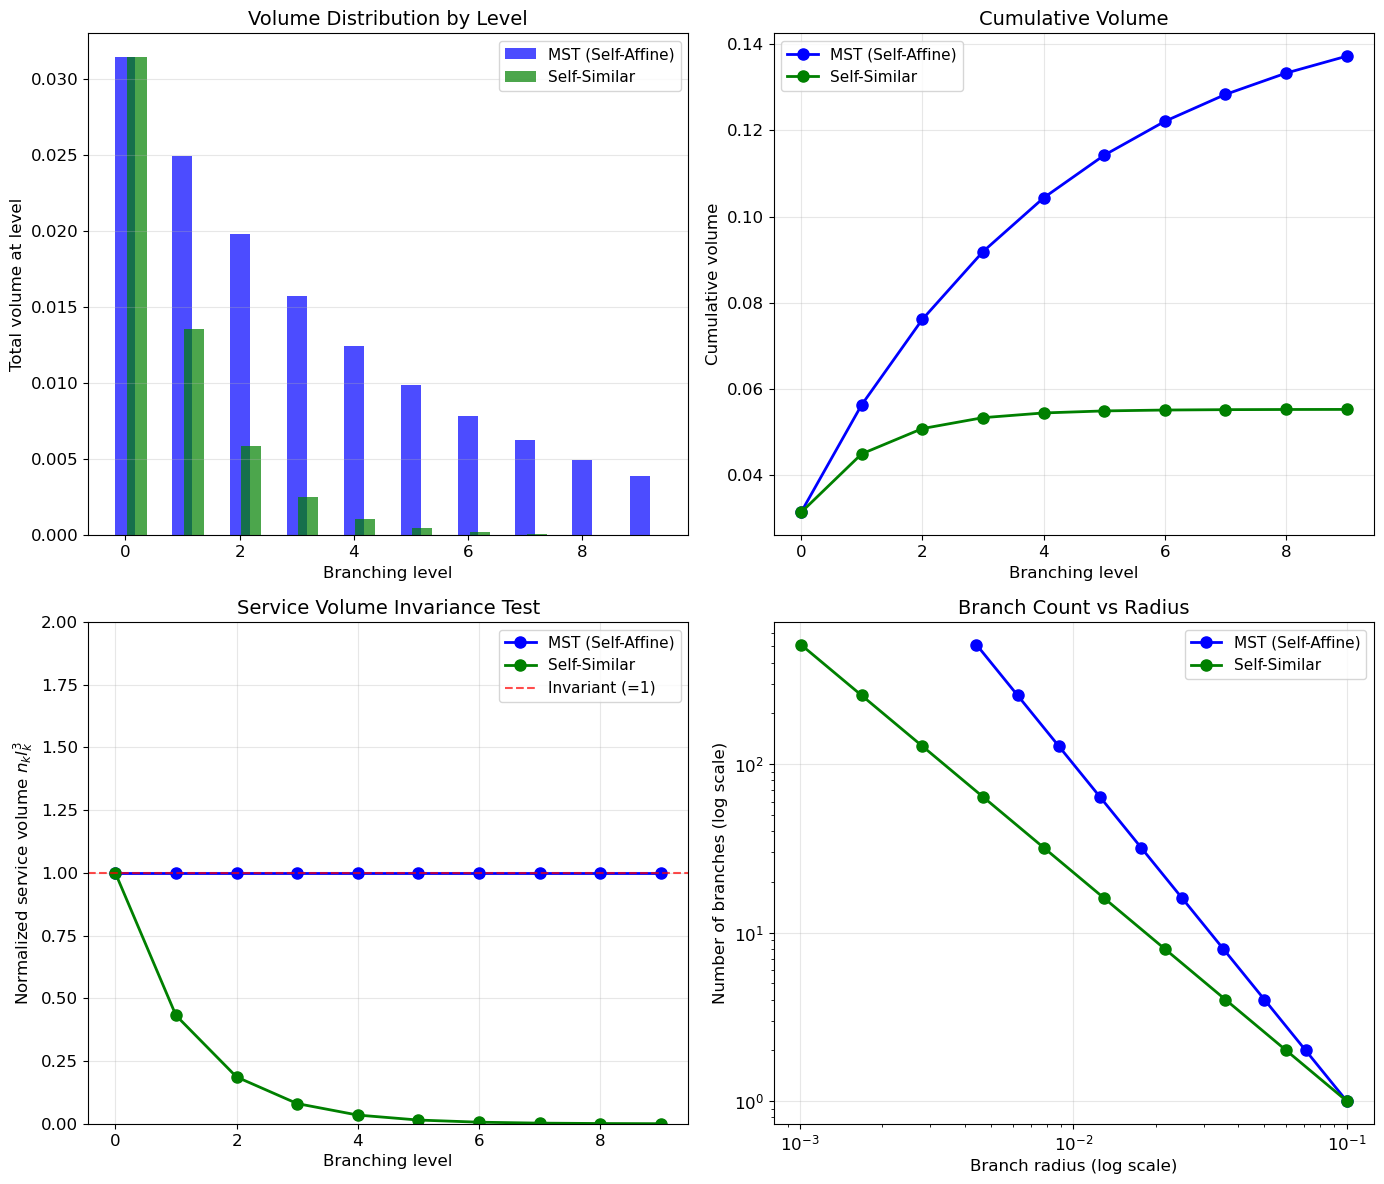


Space-filling analysis:
  MST networks maintain service volume invariance (n_k * l_k^3 ≈ constant)
  Self-similar networks deviate because γ³ ≠ 1/n


In [6]:
def analyze_volume_distribution():
    """Compare volume distributions across networks."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    networks = [
        (net_mst, stats_mst, 'MST (Self-Affine)', 'blue'),
        (net_ss, stats_ss, 'Self-Similar', 'green'),
    ]
    
    # Plot 1: Volume at each level
    ax1 = axes[0, 0]
    for net, stats, name, color in networks:
        levels = list(stats.keys())
        volumes = [stats[l]['total_volume'] for l in levels]
        ax1.bar([l + 0.2 * networks.index((net, stats, name, color)) for l in levels],
                volumes, width=0.35, alpha=0.7, color=color, label=name)
    
    ax1.set_xlabel('Branching level', fontsize=12)
    ax1.set_ylabel('Total volume at level', fontsize=12)
    ax1.set_title('Volume Distribution by Level', fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Cumulative volume
    ax2 = axes[0, 1]
    for net, stats, name, color in networks:
        levels = list(stats.keys())
        volumes = [stats[l]['total_volume'] for l in levels]
        cumulative = np.cumsum(volumes)
        ax2.plot(levels, cumulative, 'o-', color=color, linewidth=2, 
                 markersize=8, label=name)
    
    ax2.set_xlabel('Branching level', fontsize=12)
    ax2.set_ylabel('Cumulative volume', fontsize=12)
    ax2.set_title('Cumulative Volume', fontsize=14)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Service volume invariance check
    ax3 = axes[1, 0]
    for net, stats, name, color in networks:
        levels = list(stats.keys())
        # Service volume: n_k * l_k^3
        service_vol = [stats[l]['count'] * stats[l]['mean_length']**3 for l in levels]
        service_normalized = np.array(service_vol) / service_vol[0]
        ax3.plot(levels, service_normalized, 'o-', color=color, linewidth=2,
                 markersize=8, label=name)
    
    ax3.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Invariant (=1)')
    ax3.set_xlabel('Branching level', fontsize=12)
    ax3.set_ylabel('Normalized service volume $n_k l_k^3$', fontsize=12)
    ax3.set_title('Service Volume Invariance Test', fontsize=14)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 2)
    
    # Plot 4: Log-log scaling
    ax4 = axes[1, 1]
    for net, stats, name, color in networks:
        levels = list(stats.keys())
        mean_radius = [stats[l]['mean_radius'] for l in levels]
        count = [stats[l]['count'] for l in levels]
        ax4.loglog(mean_radius, count, 'o-', color=color, linewidth=2,
                   markersize=8, label=name)
    
    ax4.set_xlabel('Branch radius (log scale)', fontsize=12)
    ax4.set_ylabel('Number of branches (log scale)', fontsize=12)
    ax4.set_title('Branch Count vs Radius', fontsize=14)
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nSpace-filling analysis:")
    print("  MST networks maintain service volume invariance (n_k * l_k^3 ≈ constant)")
    print("  Self-similar networks deviate because γ³ ≠ 1/n")

analyze_volume_distribution()

## 4. Asymmetry Analysis

Real biological networks show asymmetry in their branching. Following Smith et al. (2014), we can quantify this using the **path fraction** - the ratio of minimum to maximum twig-to-trunk path lengths.

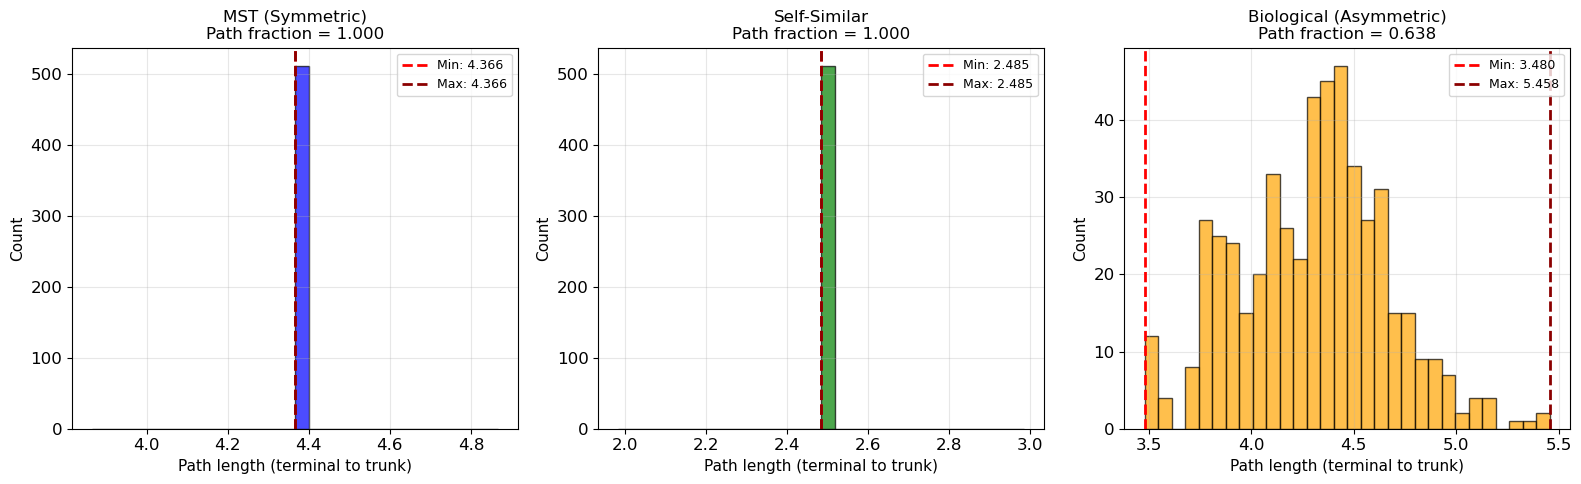


Path Fraction Analysis (Smith et al. 2014):
  Path fraction = min(path length) / max(path length)
  - PF = 1: Perfectly symmetric (self-similar)
  - PF < 1: Asymmetric (self-affine behavior)

Results:
  MST (Symmetric): PF = 1.0000
  Self-Similar: PF = 1.0000
  Biological (Asymmetric): PF = 0.6376


In [7]:
def compute_path_lengths(network):
    """
    Compute path lengths from each terminal branch to the trunk.
    """
    terminal_branches = network.get_branches_at_level(network.max_level)
    
    path_lengths = []
    
    for terminal in terminal_branches:
        # Trace back to trunk
        path_length = terminal.length
        current = terminal.parent
        
        while current is not None:
            path_length += current.length
            current = current.parent
        
        path_lengths.append(path_length)
    
    return np.array(path_lengths)

def analyze_asymmetry():
    """Analyze path fraction and asymmetry in networks."""
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    networks = [
        (net_mst, 'MST (Symmetric)', 'blue'),
        (net_ss, 'Self-Similar', 'green'),
        (net_bio, 'Biological (Asymmetric)', 'orange'),
    ]
    
    path_fractions = []
    
    for i, (net, name, color) in enumerate(networks):
        ax = axes[i]
        
        path_lengths = compute_path_lengths(net)
        
        # Plot histogram
        ax.hist(path_lengths, bins=30, color=color, alpha=0.7, edgecolor='black')
        
        # Path fraction
        pf = path_lengths.min() / path_lengths.max()
        path_fractions.append(pf)
        
        ax.axvline(path_lengths.min(), color='red', linestyle='--', 
                   linewidth=2, label=f'Min: {path_lengths.min():.3f}')
        ax.axvline(path_lengths.max(), color='darkred', linestyle='--',
                   linewidth=2, label=f'Max: {path_lengths.max():.3f}')
        
        ax.set_xlabel('Path length (terminal to trunk)', fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.set_title(f'{name}\nPath fraction = {pf:.3f}', fontsize=12)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nPath Fraction Analysis (Smith et al. 2014):")
    print("  Path fraction = min(path length) / max(path length)")
    print("  - PF = 1: Perfectly symmetric (self-similar)")
    print("  - PF < 1: Asymmetric (self-affine behavior)")
    print("\nResults:")
    for (net, name, _), pf in zip(networks, path_fractions):
        print(f"  {name}: PF = {pf:.4f}")

analyze_asymmetry()

## 5. Generating Biologically-Realistic Networks

We can create more realistic networks by incorporating:
- Gravitropic effects (branches tend upward/outward)
- Phototropic effects (branches grow toward light)
- Competition for space
- Environmental constraints

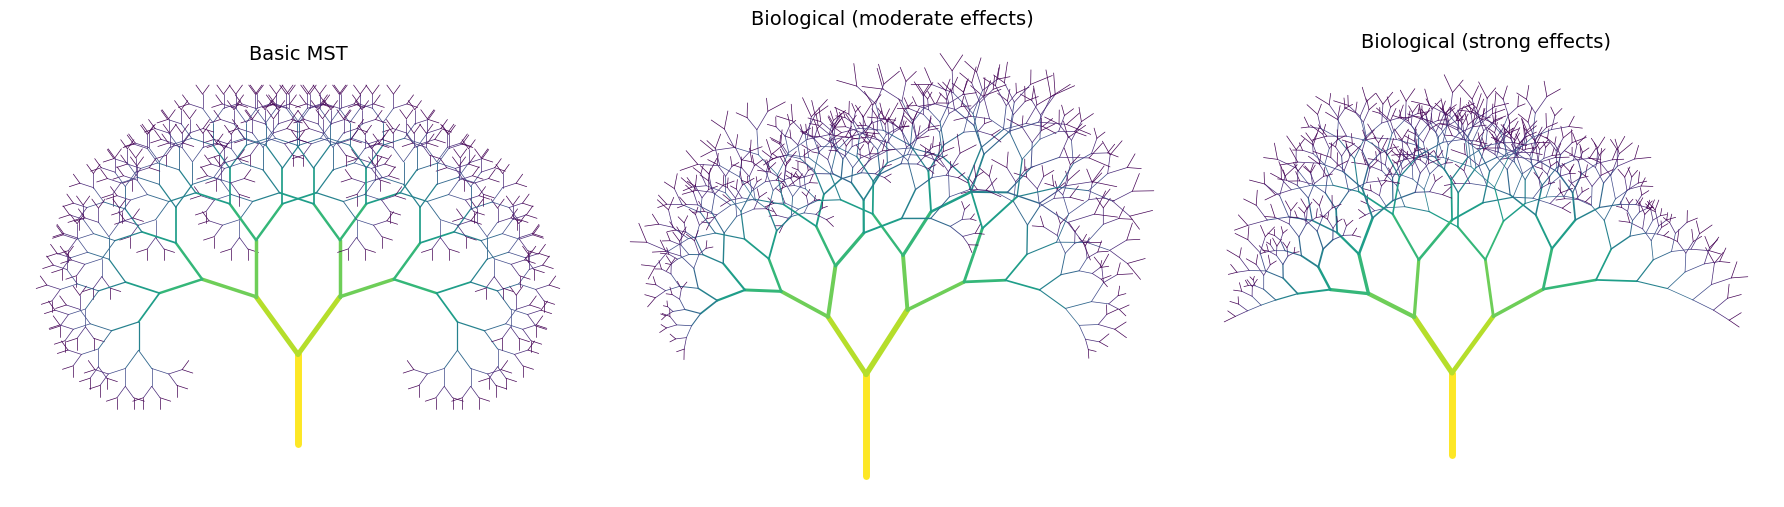


Branching ratio comparison:
Network                        Mean ξ       Mean γ       Path Fraction
------------------------------------------------------------------
Basic MST                      0.7071       0.7937       1.0000      
Bio (moderate)                 0.7137       0.7887       0.6997      
Bio (strong)                   0.7101       0.7988       0.7546      


In [8]:
class BiologicalNetwork(BranchingNetwork):
    """
    A branching network with biological-like constraints.
    """
    
    def __init__(self, *args, gravitropism=0.1, phototropism=0.05, **kwargs):
        self.gravitropism = gravitropism  # Tendency to grow upward
        self.phototropism = phototropism  # Tendency toward vertical light
        super().__init__(*args, asymmetric=True, **kwargs)
    
    def _branch(self, parent):
        """Override branching with biological constraints."""
        if parent.level >= self.max_level:
            return
        
        new_length = parent.length * self.gamma
        new_radius = parent.radius * self.xi
        
        if self.n == 2:
            angles = [-self.angle_spread, self.angle_spread]
        else:
            angles = np.linspace(-self.angle_spread * (self.n-1)/2,
                                self.angle_spread * (self.n-1)/2,
                                self.n)
        
        for i, angle_offset in enumerate(angles):
            # Add biological effects
            length_factor = 0.8 + 0.4 * np.random.random()
            radius_factor = 0.85 + 0.3 * np.random.random()
            
            # Gravitropism: pull angle toward vertical
            base_angle = parent.angle + angle_offset
            angle_to_vertical = np.pi/2 - base_angle
            gravitropic_correction = self.gravitropism * angle_to_vertical
            
            # Phototropism: some randomness toward vertical
            phototropic_noise = self.phototropism * (np.random.random() - 0.5)
            
            final_angle = base_angle + gravitropic_correction + phototropic_noise
            
            # More variation in length for outer branches
            if parent.level > self.max_level / 2:
                length_factor *= 0.9 + 0.2 * np.random.random()
            
            child = Branch(
                x=parent.end_x,
                y=parent.end_y,
                length=new_length * length_factor,
                radius=new_radius * radius_factor,
                angle=final_angle,
                level=parent.level + 1,
                parent=parent
            )
            
            parent.children.append(child)
            self.branches.append(child)
            self._branch(child)

def compare_biological_networks():
    """Compare different biological network models."""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    
    # Basic MST
    net1 = BranchingNetwork(n=2, max_level=9, angle_spread=np.pi/5)
    net1.plot(axes[0])
    axes[0].set_title('Basic MST', fontsize=14)
    
    # Biological with moderate gravitropism
    np.random.seed(42)
    net2 = BiologicalNetwork(n=2, max_level=9, angle_spread=np.pi/4.5,
                             gravitropism=0.15, phototropism=0.1)
    net2.plot(axes[1])
    axes[1].set_title('Biological (moderate effects)', fontsize=14)
    
    # Biological with strong gravitropism
    np.random.seed(123)
    net3 = BiologicalNetwork(n=2, max_level=9, angle_spread=np.pi/4,
                             gravitropism=0.25, phototropism=0.15)
    net3.plot(axes[2])
    axes[2].set_title('Biological (strong effects)', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze ratios
    print("\nBranching ratio comparison:")
    print(f"{'Network':<30} {'Mean ξ':<12} {'Mean γ':<12} {'Path Fraction':<12}")
    print("-" * 66)
    
    for net, name in [(net1, 'Basic MST'), (net2, 'Bio (moderate)'), (net3, 'Bio (strong)')]:
        xi, gamma = net.measure_branching_ratios()
        paths = compute_path_lengths(net)
        pf = paths.min() / paths.max()
        print(f"{name:<30} {np.mean(xi):<12.4f} {np.mean(gamma):<12.4f} {pf:<12.4f}")

compare_biological_networks()

## Summary

### What We Learned

1. **Branching networks can be generated** with explicit control over MST parameters

2. **Statistics extraction** allows measuring radius ratios ($\xi$) and length ratios ($\gamma$)

3. **MST predictions are validated** in synthetic networks:
   - $\xi = n^{-1/2} \approx 0.707$ for binary branching
   - $\gamma = n^{-1/3} \approx 0.794$ for binary branching

4. **Service volume invariance** ($n_k l_k^3$ = constant) is maintained in MST networks

5. **Path fraction analysis** quantifies asymmetry:
   - PF = 1: Perfectly symmetric
   - PF < 1: Asymmetric (more realistic)

### Key Insight

Even with biological noise and asymmetry, the **mean branching ratios** still follow MST predictions. The asymmetry represents natural variation around an optimal geometry.

### Next Steps

- **Notebook 4**: Measure fractal dimensions using differential box-counting
- **Notebook 5**: Validate predictions against real biological data

---

## References

- Bentley, L.P., et al. (2013). An empirical assessment of tree branching networks. Ecology Letters, 16(8), 1069-1078.
- Smith, D.D., et al. (2014). Deviation from symmetrically self-similar branching in trees. New Phytologist, 201(1), 217-229.
- West, G.B., Brown, J.H., & Enquist, B.J. (1999). A general model for the structure and allometry of plant vascular systems. Nature, 400(6745), 664-667.